In [2]:
%matplotlib inline

In [45]:
import os, sys, numpy as np, pandas as pd, scipy as sp
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib
import matplotlib.pyplot as plt

In [188]:
matplotlib.rcParams['figure.figsize'] = (12,4)

In [46]:
def haar(n, a):
    a = int(a)
    n = int(n)
    y = np.zeros(n, dtype=float)
    m = n // 2
    y[m - 2 * a:m] = 1
    y[m: m + 2 * a] = -1
    return y

def haaro(n, a):
    """Odd harr wavelet"""
    a = int(a)
    n = int(n)
    m = n // 2
    y = np.zeros(n, dtype=float)
    y[m - a:m + a] = 1
    y[m - 2 * a: m - a] = 0
    y[m + a: m + 2 * a] = 0
    return y

Denoising with rect pulse kernel transform

1.0


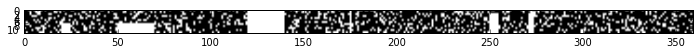

In [362]:
M = 360
Y = 12
z = np.zeros((12,M))
z[:,20:25] = 1
z[:,50:70] = 1
z[:,271:274] = 1
z[:,120:140] = 1
z[:,175:176] = 1
z[:,250:255] = 1

z[:7, :80] = 0
z[:2, 250:] = 0

z0 = np.asarray(z[:6])
# z = z+ np.random.normal(0, 0.5, z.shape)
z = z + 1*(np.random.random( z.shape) > 0.75)

z = np.clip(z, 0, 1)
plt.imshow(z, cmap='gray')
print(np.amax(z))

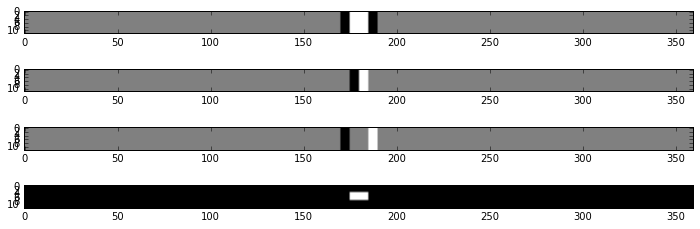

In [363]:
w = 5
kx_lp = np.zeros(z.shape)
kx_df = np.zeros(z.shape)
kx_hp = np.zeros(z.shape)
ky_bp = np.zeros(z.shape)


# kx_lp = np.ones(z.shape)
# X axis low pass
kx_lp[:,M//2-w:M//2+w] = 1
# sidebands
kx_lp[:,M//2+w:M//2+2*w] = -1
kx_lp[:,M//2-2*w:M//2-w] = -1

# X derivative
kx_df[:,M//2:M//2+w] = 1
kx_df[:,M//2-w:M//2] = -1

# X 'high pass' sorta
kx_hp[:,M//2+w:M//2+2*w] = 1
kx_hp[:,M//2-2*w:M//2-w] = -1

# kx_df[:,M//2-w:M//2] = -1

# Y bandpass
ky_bp[:,M//2-w:M//2+w] = 1
ky_bp[:4, :] = 0
ky_bp[-4:, :] = 0

ky_hp = 1- ky_bp


# kx[:5,:] = 0
nplt= 4
plt.subplot(nplt,1,1)
plt.imshow(kx_lp, cmap='gray')
plt.subplot(nplt,1,2)
plt.imshow(kx_df, cmap='gray')
plt.subplot(nplt,1,3)
plt.imshow(kx_hp, cmap='gray')
plt.subplot(nplt,1,4)
plt.imshow(ky_bp, cmap='gray')

## Notching out (penalizing stdev) works well to eliminate non-line peaks
### Better than kernel method?

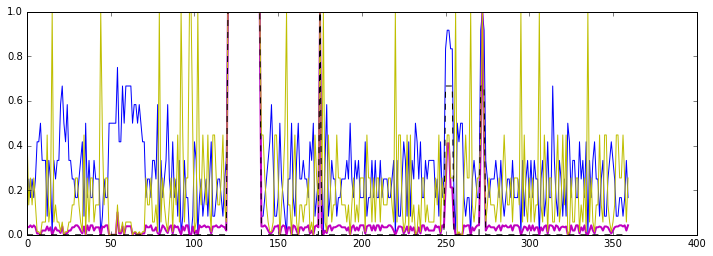

In [364]:
y_std = np.std(z, axis=0)
peak_std = np.amax(y_std)
plt.plot(np.mean(z, axis=0))
plt.plot(np.mean(z, axis=0)*(1-y_std/peak_std), lw=2, c='m')
plt.plot((1-y_std/peak_std), 'y')
plt.plot(np.mean(z0, axis=0), 'k--')


(12, 360)


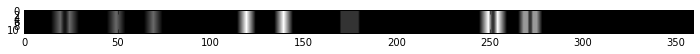

In [313]:
kf = fftpack.fft2(kx_df)
kz = fftpack.fft2(z)
ift = fftpack.fftshift(fftpack.ifft2(kf*kz))
recov = np.abs(ift)
print(recov.shape)
plt.imshow(recov, cmap='gray')

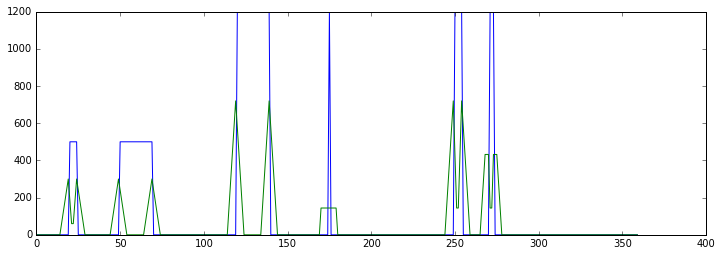

In [317]:
squash = np.sum(recov, axis=0)
meansig = np.sum(z, axis=0)*100
plt.plot(meansig)
plt.plot(squash)
# plt.plot(meansig-squash)


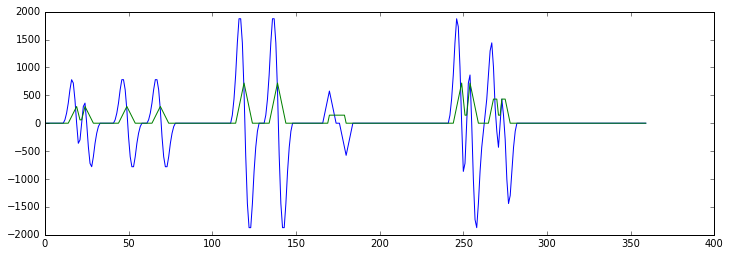

In [315]:
c = signal.cwt(squash, haar, [2])
plt.plot(c.T)
plt.plot(squash)

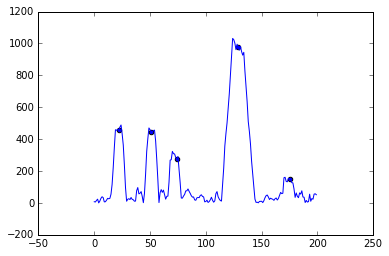

In [180]:
peaks = signal.find_peaks_cwt(squash, np.array([8.]))
plt.plot(squash)
plt.scatter(peaks, squash[peaks])

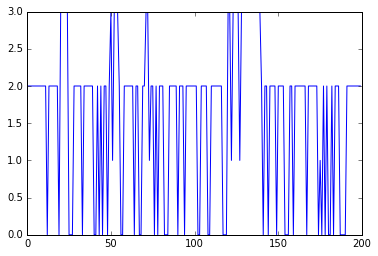

In [172]:
plt.plot(z[0,:].T)

(1, 200)


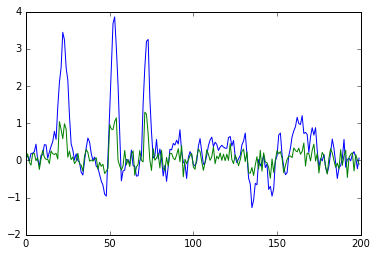

In [44]:
c = signal.cwt(z[0,:].T, haaro, [2])
print(c.shape)
plt.plot(c.T)
plt.plot(z[0,:])